## Quantitative Finance project 

The purpose of this project was to recreate a long only moving-average quantitative strategy which would allow me to showcase my ability in coding while also learning about various models and ideas in quantitative finance.

The project itself recreates a situation where an investor seeks over a year from 21-02-2018 to invest a sum N of capital in the S&P500. To make the project less computationally intensive, only the first 50 companies in the S&P500, arranged alphabetically by ticker, will be looked at.

The project therefore consists of two main parts. The signal analysis, where the historical prices of each stock are  converted into a 50 day and 20 day exponential moving averages. Stocks are considered worth investing in on a particular day if the 20 day EMA is above the 50 day EMA. The risk in the stock is calculated as the standard deviation of historic returns up to that day. The portfolio will be assembled each day so that each stock that is invested in will present the same risk to the overall protfolio.

Trading gets done daily. Each day, all pervious positions get liquidated. and the total resulting available capital get calculated. A list is created of all companies with positive crossovers on that day. Then working down the positive crossover list, an investment is calculated for the chosen stocks till no capital remains. If the calculated investment for a stock is greater than the remaining capital, then the investment is changed to be equal to the remaining capital. If the end of the list of positive crossover stocks is reached before all capital is spent then the process is iterated through again until no more capital remains.

In [1]:
!pip install pandas-datareader
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
from scipy.stats import norm

sns.set(style='darkgrid', context='talk', palette='Dark2')

You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


To start with, we fetch a list of all the S&P500 tickers by scraping and processing the HTML from the S&P500 Wikipedia page which is kept relatively up to date and has an easy strucutre to understand:

In [2]:
SP500Wiki = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
WikiTable = SP500Wiki[0]
WikiTable.head()

,0,1,2,3,4,5,6,7,8
0,Security,Symbol,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added[3][4],CIK,Founded
1,3M Company,MMM,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,0000066740,1902
2,Abbott Laboratories,ABT,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,0000001800,1888
3,AbbVie Inc.,ABBV,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888)
4,ABIOMED Inc,ABMD,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,0000815094,1981


In [3]:
sliced_table = WikiTable[1:]
header = WikiTable.iloc[0]
corrected_table = sliced_table.rename(columns=header)
corrected_table.head()

,Security,Symbol,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added[3][4],CIK,Founded
1,3M Company,MMM,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,0000066740,1902
2,Abbott Laboratories,ABT,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,0000001800,1888
3,AbbVie Inc.,ABBV,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888)
4,ABIOMED Inc,ABMD,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,0000815094,1981
5,Accenture plc,ACN,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989


Now that we have a list of all the tickers, we use Pandas.DataReader to fetch the historical price data from Yahoo for the first 50 tickers. The price data is collected from as early as 20-02-2000 purely to allow us the furthest lookback when calculating the standard deviation of the historic returns of a stock. 

The data is saved as two seperate sets to make things clearer. The first set, trainAC, is the set of what would be purely historical data that the system will already know. The second set, testAC, is the set of price data that will occur during our 1-year investment period.



In [4]:
tickers = corrected_table['Symbol'].tolist()
print(tickers[:50])
start_test_date = '2018-02-20'
end_test_date = '2019-02-20'
test_data = data.DataReader(tickers[:50], "yahoo", start_test_date, end_test_date)
start_train_date = '2000-02-20'
end_train_date = '2018-02-20'
train_data = data.DataReader(tickers[:50], 'yahoo', start_train_date, end_train_date)





['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'APC', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL']


The trainAC and testAC dataframes are now created which only contain the adjusted close price for each day 

In [5]:
trainAC = train_data[['Adj Close']]
trainAC.columns = [' '.join(col).strip() for col in trainAC.columns.values]
trainAC.head()


,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-22,56.915501,NaN,NaN,2.710376,NaN,3.089604,36.937500,6.458304,NaN,24.203232,...,3.954837,14.959162,1.013492,NaN,31.008039,NaN,NaN,2.936882,26.063425,1.777678
2000-02-23,61.580696,NaN,NaN,2.768424,NaN,3.040562,35.554649,6.216419,NaN,24.534161,...,4.020692,15.022017,0.989813,NaN,30.785164,NaN,NaN,2.887934,27.044128,1.729776
2000-02-24,66.401421,NaN,NaN,2.743492,NaN,2.942480,35.625000,6.143853,NaN,26.196444,...,4.100414,14.833460,0.994549,NaN,28.974264,NaN,NaN,2.845105,26.659605,1.708487
2000-02-25,67.256691,NaN,NaN,2.628514,NaN,2.746313,37.625000,6.204327,NaN,24.257103,...,4.100414,14.770611,0.966133,NaN,27.804150,NaN,NaN,2.783919,25.121546,1.671231
2000-02-28,62.824730,NaN,NaN,2.696980,NaN,2.844396,37.000000,6.409926,NaN,24.087805,...,4.159337,14.959162,0.951925,NaN,29.559322,NaN,NaN,2.777801,25.322964,1.708487


In [6]:
testAC = test_data[['Adj Close']]
testAC.columns = [' '.join(col).strip() for col in testAC.columns.values]
testAC.head()

,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-20,70.427200,51.183826,105.172073,169.272461,112.980812,98.167488,270.480011,58.064407,158.578491,202.979996,...,89.489143,117.275368,70.476662,78.231331,95.741318,1102.459961,1103.589966,37.919891,228.764038,60.935673
2018-02-21,70.595634,52.232834,113.807465,168.504166,112.913780,96.821785,268.250000,57.936729,157.615860,202.089996,...,89.548569,114.812935,69.859848,77.251602,96.046700,1111.339966,1113.750000,37.416100,225.951553,60.688854
2018-02-22,70.030869,52.430759,110.303398,169.912704,112.578606,95.397507,263.970001,57.936729,157.478348,202.610001,...,89.360397,116.305908,69.133583,77.143837,95.898933,1106.630005,1109.900024,37.396721,229.669098,60.128769
2018-02-23,70.050682,52.836510,116.123550,172.867706,113.718185,96.674446,268.450012,58.643871,160.061722,209.740005,...,89.954628,118.904053,71.700356,78.995514,97.327324,1126.790039,1128.089966,38.191158,230.661743,61.315384
2018-02-26,69.931793,54.429825,114.656036,176.285675,116.389961,98.796143,273.179993,59.449230,161.820007,212.149994,...,91.519386,119.611755,72.784767,79.162071,100.125000,1143.750000,1143.699951,38.297729,237.590729,62.112801


The concatenation of trainAC and testAC is what is mainly in this project and is called all_data. The previous two will be used as frames for when we need to restrict the size of a dataset. 

In [7]:
all_data = pd.concat([trainAC,testAC])
all_data.head()

,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-22,56.915501,NaN,NaN,2.710376,NaN,3.089604,36.937500,6.458304,NaN,24.203232,...,3.954837,14.959162,1.013492,NaN,31.008039,NaN,NaN,2.936882,26.063425,1.777678
2000-02-23,61.580696,NaN,NaN,2.768424,NaN,3.040562,35.554649,6.216419,NaN,24.534161,...,4.020692,15.022017,0.989813,NaN,30.785164,NaN,NaN,2.887934,27.044128,1.729776
2000-02-24,66.401421,NaN,NaN,2.743492,NaN,2.942480,35.625000,6.143853,NaN,26.196444,...,4.100414,14.833460,0.994549,NaN,28.974264,NaN,NaN,2.845105,26.659605,1.708487
2000-02-25,67.256691,NaN,NaN,2.628514,NaN,2.746313,37.625000,6.204327,NaN,24.257103,...,4.100414,14.770611,0.966133,NaN,27.804150,NaN,NaN,2.783919,25.121546,1.671231
2000-02-28,62.824730,NaN,NaN,2.696980,NaN,2.844396,37.000000,6.409926,NaN,24.087805,...,4.159337,14.959162,0.951925,NaN,29.559322,NaN,NaN,2.777801,25.322964,1.708487


Using the all_data Dataframe we can calculate the returns for each stock, the standard deviation of which will then be used to represent the risk associated with that stock

In [8]:
returns = all_data.pct_change(1)
returns.shape

(4780, 50)

As some of the stocks do not contain data before a certain date we will constrain the start of our returns dataframe for all stocks to that of the stock for which we have the least data. 

To do this we find the index for each stock at which occurs the first cell of vailid data. We assume for each stock that after this date there are no other occurances of missing data. We then take the largest returned index and use this to crop our dataframe to only include data after this date. 

In [9]:
VI = []
for i in range(len(returns.columns.values)):
    VI.append(returns[returns.columns.values[i]]. first_valid_index())
    
FVI = max(VI)
print(FVI)




2013-11-19 00:00:00


In [10]:
for i in range(len(returns)):
    
    if (returns.iloc[[i]].index.year[0] == FVI.year and returns.iloc[[i]].index.month[0] == FVI.month and returns.iloc[[i]].index.day[0] == FVI.day ):
        firstIndex = i 
        print(i)


3458


In [11]:
returnsSD = returns.iloc[firstIndex:]
returnsSD.head()

,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2013-11-19,-0.004256,-0.006967,-0.012715,0.001774,-0.008389,-0.004049,0.010004,0.020295,-0.000637,-0.014664,...,-0.001651,-0.010676,-0.035959,-0.011833,0.001457,-0.006156,-0.006156,-0.003191,-0.000615,-0.005259
2013-11-20,-0.005388,-0.007016,0.006285,-0.008758,-0.010524,0.006824,0.000367,-0.013691,-0.003950,0.003048,...,0.003190,-0.006725,0.018354,-0.012444,-0.002546,-0.002819,-0.002819,-0.010168,-0.001816,-0.005816
2013-11-21,0.010648,-0.002909,0.024265,0.011922,0.012930,0.006490,0.040337,-0.002881,0.003454,0.005184,...,0.000942,0.016848,0.008721,-0.001664,0.020668,0.011503,0.011503,0.002093,0.009057,-0.012496
2013-11-22,-0.004621,0.011672,0.000600,-0.002571,0.007618,0.003295,0.014099,0.004728,-0.007523,0.003201,...,0.001412,0.000310,-0.008069,0.005239,-0.001191,-0.002108,-0.002108,-0.001139,0.005140,0.003500
2013-11-25,-0.013742,-0.001236,0.000200,0.007580,-0.010830,0.005713,-0.018770,-0.002614,-0.008094,0.009573,...,-0.000705,-0.005263,0.011621,-0.000237,0.008825,0.013606,0.013606,-0.007222,0.001603,-0.004025


We know use the returns Dataframe to construct a new dataframe called returnsSD which will hold the standard deviations of each stock calculated using all the returns upt to the date of the current cell. This is to recreate a system that updates its risk calculations to include the previous day's returns. 

considering we will also be using returnsSD to calculate our investments we also work out the index in returnsSD, referred to as the dropIndex, at which the first date in our testAC dataframe occurs. this will allow us to later crop returnsSD to the same size as testAC. Having both dataframes with the same dimensions will make mapping the two onto each other later easier. 

In [12]:
for i in range(0, len(returnsSD)):
    
    if (returnsSD.iloc[[i]].index.year[0] == testAC.index[0].year and returnsSD.iloc[[i]].index.month[0] == testAC.index[0].month and returnsSD.iloc[[i]].index.day[0] == testAC.index[0].day ):
        dropIndex = i
        
print(dropIndex)
print(returnsSD.iloc[[dropIndex]].index)

1070
DatetimeIndex(['2018-02-20'], dtype='datetime64[ns]', name='Date', freq=None)


In [13]:
for i in range(1,len(returnsSD)):
    for j in range(len(returns.columns.values)):
        returnsSD.iat[i,j] = np.std(returnsSD[returnsSD.columns.values[j]].values[0:i])
      

In [14]:
returnsSD.head()


,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2013-11-19,-0.004256,-0.006967,-0.012715,0.001774,-0.008389,-0.004049,0.010004,0.020295,-0.000637,-0.014664,...,-0.001651,-0.010676,-0.035959,-0.011833,0.001457,-0.006156,-0.006156,-0.003191,-0.000615,-0.005259
2013-11-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-11-21,0.002128,0.003484,0.006357,0.000887,0.004195,0.002025,0.005002,0.010148,0.000318,0.007332,...,0.000825,0.005338,0.017980,0.005917,0.000729,0.003078,0.003078,0.001595,0.000307,0.002630
2013-11-22,0.002654,0.004345,0.007929,0.000724,0.005232,0.002525,0.004084,0.008286,0.000397,0.009145,...,0.001030,0.006658,0.022424,0.007379,0.000595,0.003839,0.003839,0.001990,0.000383,0.003280
2013-11-25,0.002721,0.004455,0.008129,0.000631,0.005364,0.002589,0.003559,0.007221,0.000407,0.009376,...,0.001056,0.006826,0.022990,0.007566,0.000518,0.003936,0.003936,0.002040,0.000393,0.003362


As mentioned before, we now limit the dimensions of the dataframe to that of trainAC:

In [15]:
returnsSD = returnsSD.drop(returnsSD.index[:dropIndex])
returnsSD



,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-21,0.000312,0.000511,0.000933,0.000082,0.000616,0.000297,0.000465,0.000944,0.000047,0.001076,...,0.000121,0.000784,0.002639,0.000869,0.000068,0.000452,0.000452,0.000234,0.000045,0.000386
2018-02-22,0.000312,0.000511,0.000933,0.000082,0.000616,0.000297,0.000465,0.000944,0.000047,0.001076,...,0.000121,0.000783,0.002638,0.000868,0.000068,0.000452,0.000452,0.000234,0.000045,0.000386
2018-02-23,0.000312,0.000511,0.000933,0.000082,0.000615,0.000297,0.000465,0.000943,0.000047,0.001076,...,0.000121,0.000783,0.002638,0.000868,0.000068,0.000452,0.000452,0.000234,0.000045,0.000386
2018-02-26,0.000312,0.000511,0.000932,0.000082,0.000615,0.000297,0.000465,0.000943,0.000047,0.001075,...,0.000121,0.000783,0.002637,0.000868,0.000068,0.000451,0.000451,0.000234,0.000045,0.000386
2018-02-27,0.000312,0.000511,0.000932,0.000082,0.000615,0.000297,0.000465,0.000943,0.000047,0.001075,...,0.000121,0.000783,0.002636,0.000867,0.000068,0.000451,0.000451,0.000234,0.000045,0.000385
2018-02-28,0.000312,0.000511,0.000932,0.000082,0.000615,0.000297,0.000464,0.000942,0.000047,0.001075,...,0.000121,0.000782,0.002635,0.000867,0.000068,0.000451,0.000451,0.000234,0.000045,0.000385
2018-03-01,0.000312,0.000510,0.000931,0.000082,0.000615,0.000297,0.000464,0.000942,0.000047,0.001074,...,0.000121,0.000782,0.002634,0.000867,0.000068,0.000451,0.000451,0.000234,0.000045,0.000385
2018-03-02,0.000312,0.000510,0.000931,0.000082,0.000614,0.000297,0.000464,0.000942,0.000047,0.001074,...,0.000121,0.000782,0.002633,0.000867,0.000068,0.000451,0.000451,0.000234,0.000045,0.000385
2018-03-05,0.000312,0.000510,0.000931,0.000082,0.000614,0.000296,0.000464,0.000941,0.000047,0.001073,...,0.000121,0.000782,0.002632,0.000866,0.000068,0.000451,0.000451,0.000234,0.000045,0.000385


We now also workout the index for all_data which will allow us to crop any subsequent dataframes of the same size so that they have the same date range as testAC. The reason we do this rather than use testAC is that when calculating our 50 day and 20 day exponential moving averages, we will need data before the testAC start date to establish the moving avergae for that date.

In [16]:
for i in range(len(all_data)):
    
    if (all_data.iloc[[i]].index.year[0] == testAC.index[0].year and all_data.iloc[[i]].index.month[0] == testAC.index[0].month and all_data.iloc[[i]].index.day[0] == testAC.index[0].day ):
        ADIndex = i 
print(ADIndex)

4528


Now that we have all of our constituent dataframes, what we need is to create the crossover signal between the 20 day and 50 day EMA. This will be our indicator of which stocks are likely trending upwards.

An example of this crossover for Abiomed (ABMD) is shown in the timeseries graph below. 

We also define our positions dataframe which is initially blank and a returns multiplier dataframe which will allow us to calculate the change in value of our previous days positions.  

In [17]:
ema_20 = all_data.ewm(span=20, adjust=False).mean()
ema_20Test = ema_20.drop(ema_20.index[:ADIndex])
ema_50 = all_data.ewm(span=50, adjust=False).mean()
ema_50Test = ema_50.drop(ema_50.index[:ADIndex])
ema_cross = ema_20Test - ema_50Test
positions = testAC.copy()
positions[:] = 0
returnsRedacted = returns[ADIndex:]
returnsMultiplier = returnsRedacted +1


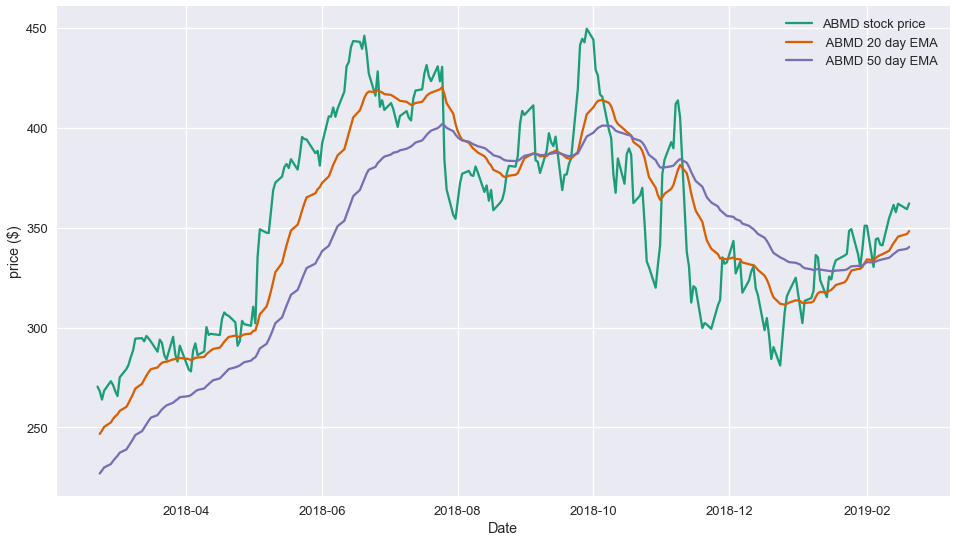

In [18]:
fig, ax1 = plt.subplots(figsize=(16,9))

ax1.plot(testAC.index, testAC.loc[:, 'Adj Close ABMD'], label="ABMD stock price")
ax1.plot(ema_20Test.index, ema_20Test.loc[:, 'Adj Close ABMD'], label=' ABMD 20 day EMA')
ax1.plot(ema_50Test.index, ema_50Test.loc[:, 'Adj Close ABMD'], label=' ABMD 50 day EMA')

ax1.set_xlabel('Date')
ax1.set_ylabel('price ($)')
ax1.legend()

This section is now where we bring together all the previoulsy created Dataframes to produce our positions dataframe which will list the value invested in each stock each day over the year.

It works by iterating through each day of the year and calculating the list of positive crossover stocks, ordered from largest to smallest positive crossover. For each day of the year it then iterates through the list and calculates the amount that day to invest for the stock based on investing enough in each stock so that they each pose the same risk to the portfolio. More precisely they each are expected to lose the same amount over a given time frame for a given confidence level.

This is done by calculating the product of the capital (N) available that day, the desired risk (scaledRisk) and the inverse of the standard deviation of that stocks historic returns up to that day.

The resulting quantity is then inputed into the column for that stock on that day in the positions dataFrame. 

The capital available each day is calculated as the total worth of the positions being held the previous day once adjusted for any returns or losses they have made. On the first day (i=0), N is simply what it was originally assigned to be.

In [19]:
N = 1000000
scaledRisk = 0.00005
spentCapital = 0
Totalpositions = 0

for i in range(0,len(ema_cross)):
    if i == 0:
        priorityList = ema_cross.iloc[[i]].transpose()
        priorityListOrd = priorityList.sort_values(by=[priorityList.columns.values[0]], ascending=False)
        priorityListOrd = priorityListOrd.reset_index()
        
        for k in range(len(priorityListOrd)):
            if priorityListOrd.iat[k,1] <=0:
                PDI = k
                break
        investOpp = priorityListOrd[0:k-1]
        
        while spentCapital < N:
            for j in range(len(investOpp)):
                stockAlloc = N* scaledRisk /returnsSD[[investOpp.iat[j,0]]].iat[i,0]
                
                if stockAlloc < (N-spentCapital):
                    positions.at[positions.index[i],investOpp.iat[j,0]] += stockAlloc
                    spentCapital += stockAlloc
                
                elif stockAlloc >= (N - spentCapital):
                    positions.at[positions.index[i],investOpp.iat[j,0]] += (N-spentCapital)
                    spentCapital += (N-spentCapital)
                    
                    
                    break
    else:
        NRaw = positions.iloc[[0]]
        NRaw[:] = 0
        for j in range(len(NRaw.columns.values)):
            NRaw.at[NRaw.index[0],NRaw.columns.values[j]] = positions.iat[i-1,j] * returnsMultiplier.iat[i,j]
        N = np.sum(NRaw.values)
        
        spentCapital = 0
        
        priorityList = ema_cross.iloc[[i]].transpose()
        priorityListOrd = priorityList.sort_values(by=[priorityList.columns.values[0]], ascending=False)
        priorityListOrd = priorityListOrd.reset_index()
        
        for l in range(len(priorityListOrd)):
            if priorityListOrd.iat[l,1] <=0:
                PDI = l
                break
        investOpp = priorityListOrd[0:l-1]
        
        while spentCapital < N:
            for m in range(len(investOpp)):
                stockAlloc = N* scaledRisk /returnsSD[[investOpp.iat[m,0]]].iat[i,0]
                
                if stockAlloc < (N-spentCapital):
                    positions.at[positions.index[i],investOpp.iat[m,0]] += stockAlloc
                    spentCapital += stockAlloc
                    
                
                elif stockAlloc >= (N - spentCapital):
                    positions.at[positions.index[i],investOpp.iat[m,0]] += (N-spentCapital)
                    spentCapital += (N-spentCapital)
                    
                    
                    break
        

    

/Users/Alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Alex/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer(key, value)
/Users/Alex/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return self._setitem_sli

The resulting positions Data frame containing the invested amounts for each day can be seen below:

In [20]:
positions.tail()

,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-13,0.0,0.0,0.0,0.0,0.0,0.0,126316.472874,0.0,0.0,54607.804364,...,0.0,75008.133745,0.0,0.0,0.0,130085.280058,130084.590784,0.0,0.0,0.0
2019-02-14,0.0,0.0,0.0,0.0,0.0,0.0,126420.440015,0.0,0.0,54652.778619,...,0.0,75069.909438,0.0,0.0,0.0,130192.416549,130191.726707,0.0,0.0,0.0
2019-02-15,0.0,0.0,0.0,0.0,0.0,0.0,126524.465142,0.0,0.0,54697.777935,...,0.0,75131.719554,0.0,0.0,0.0,130299.612741,130298.922331,0.0,0.0,0.0
2019-02-19,0.0,0.0,0.0,0.0,0.0,0.0,126628.548299,0.0,0.0,54742.802332,...,0.0,0.000000,0.0,0.0,0.0,130406.868678,130406.177700,0.0,0.0,0.0
2019-02-20,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [21]:
NRaw = positions.iloc[[0]]
for j in range(len(NRaw.columns.values)):
    NRaw.at[NRaw.index[0],NRaw.columns.values[j]] = positions.iat[-2,j] * returnsMultiplier.iat[-1,j]
N = np.sum(NRaw.values)
PortfolioReturn = (N - 1000000)/1000000*100

The portfolio yearly return is therefore: 

In [22]:
PortfolioReturn

9.487502800507006


Though this project has been a great learning experience, I have had, due to time and knowledge constraints, to make certain assumptions and limitations that affect the efficiency and validity of this system.

Firstly, The EMA crossovers for each stock, which are what are used to order which stocks get priority for investment, have not been adjusted to be proportional to the price of the stock which would bias the system towards more expensive stocks.

Secondly, the risk calculations that tried to equalise the risk from each position were made slightly redundant by the fact that the system, sometimes had to loop back over the list and double the amount invested in some stocks just to spend all the available capital. This defeated the whole point that each stock would present the same risk to the portfolio, however this is more an issue with the restriction to 50 S&P500 companies as if all had been available the positive crossover list would hopefully have been long enough to make any double purchases unneccessary.

Fourthly, because my only signal is a simple EMA crossover, there can often be a lot of inefficient investing that comes from noise. A possible way to solve this might be to wait for at least two consecutive positive crossover days before investing but this could potentially also lose money by reacting slowly to positive trends and so mighnt only be effective with EMA's with longer lookbacks.

Thirdly and most importantly, This system does not take into account any of the trading costs of liquidating the entire portfolio and reinvesting it every day. Even if this process was optimised to just trade the difference in positions between days the, difference to returns would be noticeable. 